<a href="https://colab.research.google.com/github/Last-Vega/Klis_Workshop_MachineLearning/blob/master/ML7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# zipファイルを展開する
!unzip cat_dog_images.zip

Archive:  cat_dog_images.zip
   creating: cat_dog_images/
  inflating: cat_dog_images/.DS_Store  
  inflating: __MACOSX/cat_dog_images/._.DS_Store  
   creating: cat_dog_images/0/
   creating: cat_dog_images/1/
  inflating: cat_dog_images/0/00132.jpg  
  inflating: cat_dog_images/0/02057.jpg  
  inflating: cat_dog_images/0/00898.jpg  
  inflating: cat_dog_images/0/01210.jpg  
  inflating: cat_dog_images/0/01576.jpg  
  inflating: cat_dog_images/0/01562.jpg  
  inflating: cat_dog_images/0/01204.jpg  
  inflating: cat_dog_images/0/01589.jpg  
  inflating: cat_dog_images/0/00683.jpg  
  inflating: cat_dog_images/0/00873.jpg  
  inflating: cat_dog_images/0/01748.jpg  
  inflating: cat_dog_images/0/01990.jpg  
  inflating: cat_dog_images/0/00456.jpg  
  inflating: cat_dog_images/0/00324.jpg  
  inflating: cat_dog_images/0/00442.jpg  
  inflating: cat_dog_images/0/01012.jpg  
  inflating: cat_dog_images/0/00318.jpg  
  inflating: cat_dog_images/0/01006.jpg  
  inflating: cat_dog_images/0/019

In [2]:
import torchvision # PyTorchの中でも特に画像データの扱いに特化したパッケージ
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 画像に対して実行する前処理を定義するクラス
class ImageTransform():
    def __init__(self):
        self.data_transform = transforms.Compose([
            transforms.Resize((224, 224)), # 画像のサイズを揃える必要があるので224 x 224に統一
            transforms.ToTensor()
        ])
    
    def __call__(self, img):
        return self.data_transform(img)

# torchvision.datasets.ImageFolderは
# あるフォルダ中に含まれるフォルダ名をラベルとして，その中に含まれる画像はそのラベルが付与されていると解釈し，
# 画像データを読み込む
image_dir = "/content/cat_dog_images" # アップロードしたzipファイルがcat_dog_imagesというフォルダに展開されるはず
dataset = torchvision.datasets.ImageFolder(image_dir, transform=ImageTransform())

In [3]:
from torch.utils.data import DataLoader, random_split

train_size = 167 # 先頭の167件を訓練データとして用いることにする
batch_size = 32 # ミニバッチのサイズを設定，増やしても減らしても良い

# 訓練データとテストデータに分割
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset)-train_size])

# 訓練データを読み込むためのデータローダーを準備．shuffle=Trueはミニバッチを作る際に，画像の順序をランダムにするオプション．
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [4]:
import torchvision.models as models
import torch.nn as nn

model = models.vgg11() # vgg11モデルのインスタンスを作成
num_ftrs = model.classifier[6].in_features # 最後の層の入力次元数を取得
model.classifier[6] = nn.Linear(num_ftrs, 1) # 2クラス分類用に出力層を修正．これを行う場合と行わない場合で出力を比べると良い．

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [5]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # CPUもしくはGPUのどちらを使うかを設定
model = model.to(device) # CPUもしくはGPUのどちらを設定
optimizer = optim.Adam(model.parameters()) # 基本的な学習方法はミニバッチ勾配降下法ではあるが，その中でもよく用いられるAdamと呼ばれる方法を用いることにする

criterion = nn.BCEWithLogitsLoss() # 二値分類用の交差エントロピーを最小化することにする

epoch_size = 10 # 勾配降下法はすべてのデータでパラメータを更新したら終わりではなく，全データでの更新（=1エポック）を複数回行う必要がある

model.train() # モデルを学習モードに変更

# `epoch_size`の数だけ以下を繰り返す
for epoch in range(epoch_size):
    losses = []
    # データローダーはミニバッチ勾配降下法のために，`batch_size`で指定した数ごとにデータをわけて読み込んでくれる．
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() # 勾配の初期化
        y = model(images) # 現時点でのモデルの出力を得る
        y = y.squeeze() # yは`batch_size` x 1の**行列**になっているので，これを`batch_size`次元の**ベクトル**に変換
        loss = criterion(y, labels.type(torch.float)) # 交差エントロピーの計算
        loss.backward() # 交差エントロピーの勾配計算
        optimizer.step() # パラメータ更新
        losses.append(loss.item())

    # 現在の交差エントロピーを出力
    print('Epoch: {}\tCross Entropy: {:.6f}'.format(epoch, sum(losses)))

Epoch: 0	Cross Entropy: 47.935311
Epoch: 1	Cross Entropy: 4.212570
Epoch: 2	Cross Entropy: 4.169911
Epoch: 3	Cross Entropy: 4.158730
Epoch: 4	Cross Entropy: 4.149626
Epoch: 5	Cross Entropy: 4.173991
Epoch: 6	Cross Entropy: 4.177493
Epoch: 7	Cross Entropy: 4.161660
Epoch: 8	Cross Entropy: 4.156039
Epoch: 9	Cross Entropy: 4.161995


In [6]:
correct = 0
model.eval() # モデルを評価モードに変更
for batch_idx, (images, labels) in enumerate(test_dataloader):
    images, labels = images.to(device), labels.to(device)
    y = model(images) # モデルの出力を得る
    y = y.squeeze()
    result = torch.sigmoid(y) # `ImageClassifier`ではsigmoid関数を適用していなかったのでここで適用
    prediction = result >= 0.5 # `result`ベクトルと同じ次元を持ち，`result`の中で0.5以上である次元がTrue，それ以外がFalseであるベクトルを`prediction`とする
    target = labels == 1 # `labels`ベクトルと同じ次元を持ち，`labels`の中で1である次元がTrue，それ以外がFalseであるベクトルを`target`とする
    correct_num = target.eq(prediction).sum().item() # `prediction`ベクトルと`target`ベクトルでTrue/Falseが一致したものの数を数える
    correct += correct_num

# test_dataloader.datasetにはテストデータ全体が入っているので，これの長さはテストデータの事例数となる
print("Accuracy: {:.3f}".format(correct / len(test_dataloader.dataset)))


Accuracy: 0.504


In [7]:
import torchvision.models as models
import torch.nn as nn

model = models.vgg11(pretrained=True) # 事前学習モデルを利用
for param in model.parameters(): # モデル中のパラメータ
    param.requires_grad = False # 事前学習モデルのパラメータ更新を停止
num_ftrs = model.classifier[6].in_features # 最後の層の入力次元数を取得
model.classifier[6] = nn.Linear(num_ftrs, 1) # 2クラス分類用に出力層を修正．この層だけは学習される．

model

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

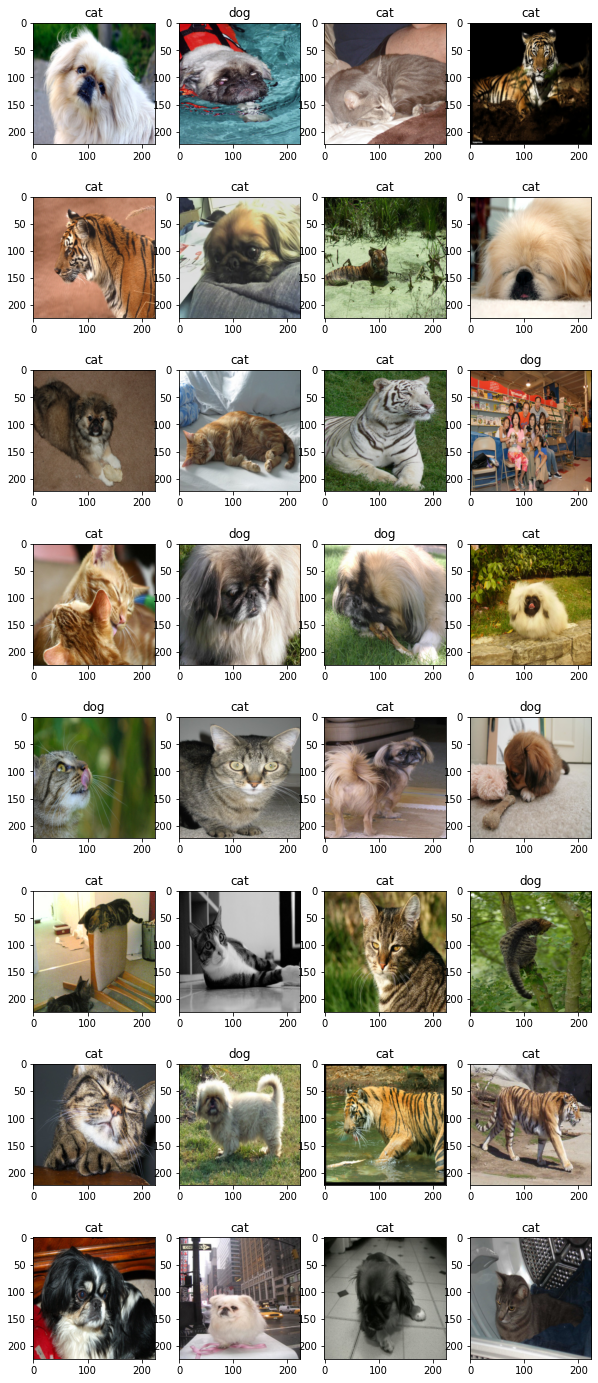

In [8]:
# VGGの事前学習モデルを再学習し，その予測結果を表示してみよう

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 25)) # 10 x 25の画像表示域を確保

for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)
    y = model(images) # モデルの出力を得る
    result = torch.sigmoid(y) # `ImageClassifier`ではsigmoid関数を適用していなかったのでここで適用
    # 得られたミニバッチ中の各画像を表示してみる
    for i in range(batch_size):
      if isinstance(images[i], torch.Tensor):
        im = images[i].cpu().permute(1, 2, 0) # 表示用の変換
      else:
        im = images[i].permute(1, 2, 0) # 表示用の変換
      ax = fig.add_subplot(8, 4, i+1) # 8行4列のうち，i+1番目のマスを選択
      label_name = "dog" if result[i] >= 0.5 else "cat" # 結果が0.5以上なら犬，そうでなければ猫
      ax.set_title(label_name) # マスにタイトルを設定
      ax.imshow(im) # 画像を表示
    break # ミニバッチは複数あるが，1個読み込んだら終わるようにbreakをここに入れている